In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


In [4]:
# loading the data 
df_2 = pd.read_csv("PDB_Load_History.csv")
df_2['date'] = pd.to_datetime(df_2['date'])

In [6]:
df_2.head(10)

,date,year,month,day,weekday,hour,demand,temperature
0,2003-03-01,2003,3,1,7,1,12863.0,29
1,2003-03-01,2003,3,1,7,2,12389.0,28
2,2003-03-01,2003,3,1,7,3,12155.0,29
3,2003-03-01,2003,3,1,7,4,12072.0,27
4,2003-03-01,2003,3,1,7,5,12160.0,29
5,2003-03-01,2003,3,1,7,6,12568.0,28
6,2003-03-01,2003,3,1,7,7,13236.0,29
7,2003-03-01,2003,3,1,7,8,14190.0,29
8,2003-03-01,2003,3,1,7,9,15213.0,28
9,2003-03-01,2003,3,1,7,10,15647.0,27


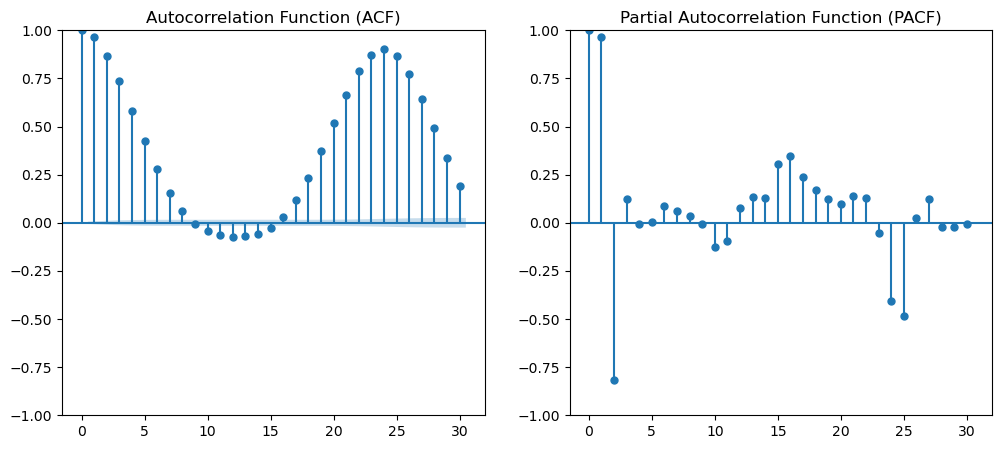

In [70]:
# checking dependencies between time points 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = df_2["demand"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(ts, lags=30, ax=axes[0])  
plot_pacf(ts, lags=30, ax=axes[1]) 

axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [8]:
# splitting the data 
split_idx = int(len(df_2['demand']) * 0.8)
train_data = df_2[:split_idx]
test_data = df_2[split_idx:]
train_data = train_data.drop(['date'], axis=1)
test_data = test_data.drop(['date'], axis=1)

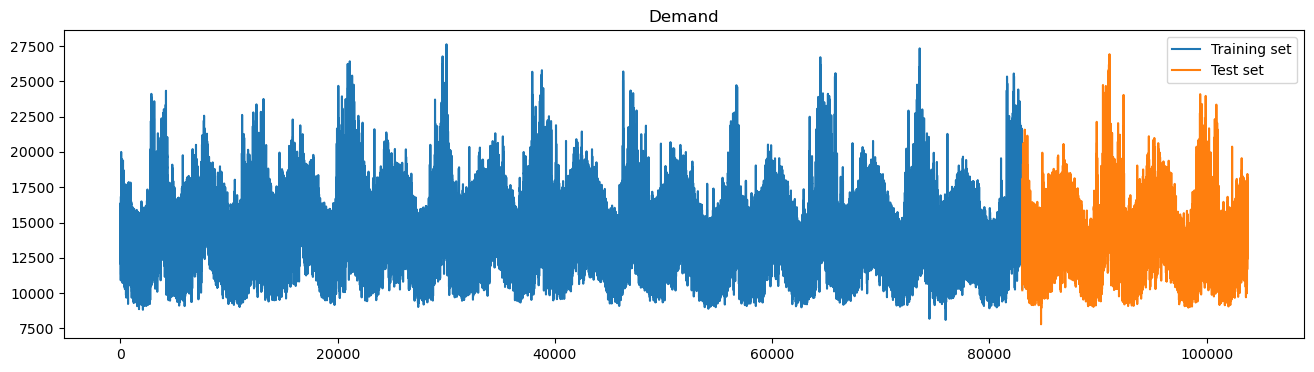

In [10]:
df_2["demand"][:split_idx].plot(figsize=(16,4),legend=True)
df_2["demand"][split_idx:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('Demand')
plt.show()

In [12]:
# scaling the features 
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [32]:
# creating the train and validation sets 
def create_lags(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 5] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_train_2, y_train_2 = create_lags(scaled_train_data, 14)
x_test_2, y_test_2 = create_lags(scaled_test_data, 14)

In [20]:
print('shape of X_train:', x_train_2.shape)
print('shape of X_test:', x_test_2.shape)
print('shape of y_train:', y_train_2.shape)
print('shape of y_test:', y_test_2.shape)

shape of X_train: (83013, 7, 7)
shape of X_test: (20749, 7, 7)
shape of y_train: (83013,)
shape of y_test: (20749,)


In [22]:
# building the model 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Softmax, Multiply, Flatten, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

In [23]:
def build_model(input_shape, lstm_units, dense_units, dropout_rate, activation):
    inputs = Input(shape=input_shape, name='Input_Layer')
    lstm_out1 = Bidirectional(LSTM(lstm_units, return_sequences=True, name='LSTM_Layer_1'))(inputs)
    lstm_out1 = BatchNormalization(name="BatchNorm_1")(lstm_out1) 
    lstm_out2 = Bidirectional(LSTM(lstm_units // 2, return_sequences=True, name='LSTM_Layer_2'))(lstm_out1)
    lstm_out2 = Dropout(dropout_rate, name="Dropout_LSTM_2")(lstm_out2)  
    attention_scores = Dense(1, activation='tanh', name='Attention_Scores')(lstm_out2)
    attention_weights = Softmax(axis=1, name='Attention_Weights')(attention_scores)
    attention_output = Multiply(name='Attention_Apply')([lstm_out2, attention_weights])
    flattened_output = Flatten(name='Flatten')(attention_output)
    dense1 = Dense(dense_units, activation=activation, name='Dense_1')(flattened_output)
    dense1 = Dropout(dropout_rate, name='Dropout_1')(dense1)

    dense2 = Dense(dense_units // 2, activation=activation, name='Dense_2')(dense1)
    dense2 = Dropout(dropout_rate, name='Dropout_2')(dense2)

    outputs = Dense(1, activation='linear', name='Output_Layer')(dense2)

    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Attention_Model')
    return model

In [44]:
# training the model with early stopping mechanism 
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model = build_model(input_shape=(14, 7), lstm_units=256, dense_units=128, dropout_rate=0.4, activation="relu")

lstm_model.compile(optimizer=Adam(learning_rate=0.005),loss='mse', metrics=['mae'])
history = lstm_model.fit(x_train_2, y_train_2,
        validation_data=(x_test_2, y_test_2),
        batch_size=125,
        epochs=30,
        callbacks=[early_stopping],
        verbose=1)

Epoch 1/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 169s 234ms/step - loss: 0.0138 - mae: 0.0761 - val_loss: 0.0035 - val_mae: 0.0460
Epoch 2/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 157s 236ms/step - loss: 0.0023 - mae: 0.0344 - val_loss: 0.0032 - val_mae: 0.0475
Epoch 3/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 157s 236ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 0.0045 - val_mae: 0.0514
Epoch 4/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 156s 234ms/step - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0024 - val_mae: 0.0402
Epoch 5/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 158s 238ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0027 - val_mae: 0.0431
Epoch 6/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 162s 244ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0028 - val_mae: 0.0400
Epoch 7/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 152s 228ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0017 - val_mae: 0.0302
Epoch 8/30
665/665 ━━━━━━━━━━━━━━━━━━━━ 159s 239ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 9/30
665/665 ━━━━━

In [46]:
lstm_model.summary()

Model: "Optimized_LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 14, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 14, 512)   │    540,672 │ Input_Layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNorm_1         │ (None, 14, 512)   │      2,048 │ bidirectional_10… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 14, 256)   │    656,384 │ BatchNorm_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_LSTM_2      │ (None, 14, 256)   │          0 │ bidirectional_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_Scores    │ (None, 14, 1)     │        257 │ Dropout_LSTM_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_Weights   │ (None, 14, 1)     │          0 │ Attention_Scores… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_Apply     │ (None, 14, 256)   │          0 │ Dropout_LSTM_2[0… │
│ (Multiply)          │                   │            │ Attention_Weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 3584)      │          0 │ Attention_Apply[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 128)       │    458,880 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 128)       │          0 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      8,256 │ Dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 64)        │          0 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 1)         │         65 │ Dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,997,640 (19.06 MB)

 Trainable params: 1,665,538 (6.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 3,331,078 (12.71 MB)

In [48]:
loss = lstm_model.evaluate(x_test_2, y_test_2)
print(f"Model Evaluation:\nMAE: {loss}")

649/649 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 1.9587e-04 - mae: 0.0098
Model Evaluation:
MAE: [0.00019948968838434666, 0.009989749640226364]


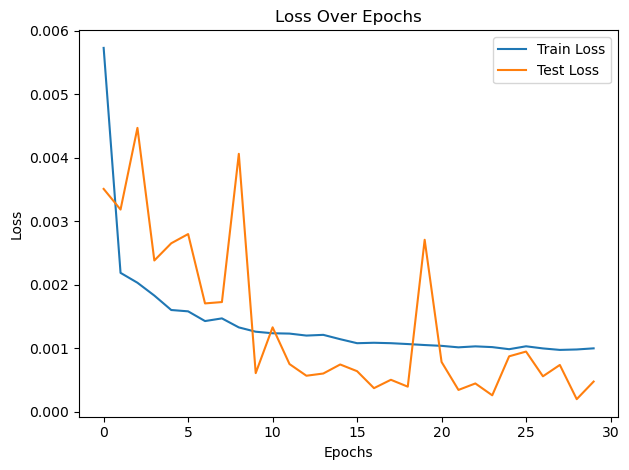

In [50]:
# train VS test loss 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
# predicting values for the test set 
predicted = lstm_model.predict(x_test_2)

649/649 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step


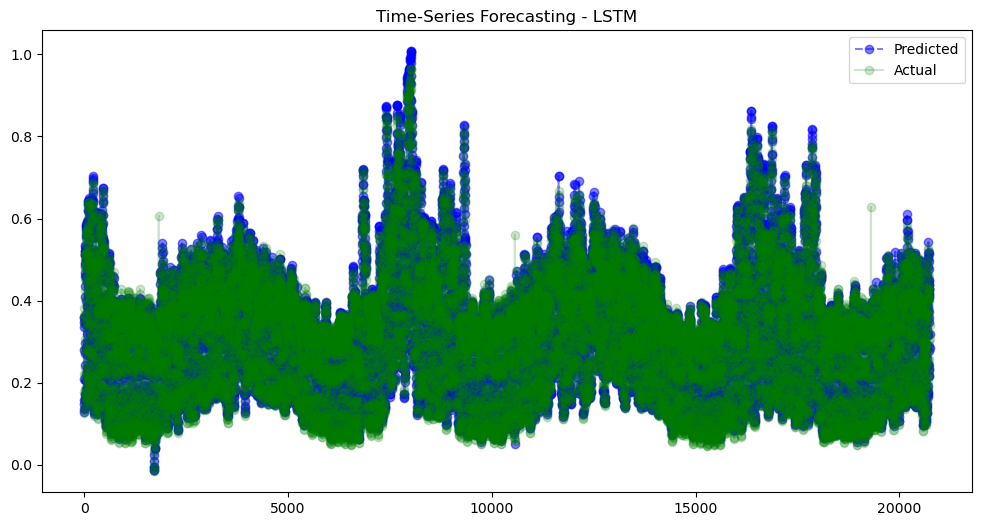

In [66]:
#plotting the predictions agains actual test values 
plt.figure(figsize=(12, 6))
plt.plot(predicted, label="Predicted", linestyle="dashed", marker='o', color="blue", alpha = 0.5)
plt.plot(y_test_2, label="Actual", marker='o', color = 'green', alpha = 0.2)
plt.title("Time-Series Forecasting - LSTM")
plt.legend()
plt.show()
